# Compact

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.utils.tensorboard import SummaryWriter

In [148]:
class MyGraph:
    def __init__(self, width: int = 5, height: int = 5):
        self.width = width  # y-axis
        self.height = height  # x-axis
        # self.G = nx.generators.lattice.grid_2d_graph(
        #     self.height, self.width, create_using=nx.DiGraph
        # )
        # self.G = nx.DiGraph(nx.dense_gnm_random_graph(width, int(width*2)))
        self.G = nx.from_numpy_array(self.construct_random_subgraph(width), create_using=nx.DiGraph())
        self.adj_matrix = nx.adjacency_matrix(self.G).toarray()
        self.nodes_list = list(self.G.nodes.keys())
        self.edge_indices = self.calc_node_action_pairs()
        self.action_dim = None
        self.state_dim = None
        self.action_method = None
        self.state_method = None
    
    def construct_random_subgraph(self, num_nodes, min_edges=2, max_edges=5):
        min_edges-=1
        max_edges-=1
        connections = np.random.uniform(size=(num_nodes, num_nodes))
        connections += np.roll(np.eye(num_nodes), 1, 1)  # make sure every node is connected
        connections -= np.eye(num_nodes)  # make sure no self-connections
        # set strongest connections
        sorted_connections = np.sort(connections)[:, ::-1]
        min_edges = min_edges
        max_edges = max_edges + 1
        min_edges = int(min_edges / 2 + 0.5)  # used to be min_edges // 2
        max_edges = int(max_edges / 2 + 0.5)
        indices = np.stack([np.arange(num_nodes), np.random.randint(min_edges, max_edges, num_nodes)])
        thresholds = sorted_connections[indices[0], indices[1]]
        connections = np.where(connections > thresholds[:, None], 1., 0.).astype(np.float32)
        connections = np.clip(connections + connections.T, 0, 1)
        return connections

    def calc_node_action_pairs(self) -> dict[(int, int) : int]:
        edge_indices = {}
        for edge_idx, edge in enumerate(self.G.edges()):
            # from_node, to_node = edge
            # from_node_idx = self.nodes_list.index(from_node)
            # to_node_idx = self.nodes_list.index(to_node)
            edge_indices[edge] = edge_idx
        return edge_indices

    def calc_action_between_cur_and_next_node(
        self, curr_node: int, next_node: int
    ) -> int:
        """
        each node has 4 actions: [S, N, W, E]
        """
        curr_x, curr_y = self.nodes_list[curr_node]
        next_x, next_y = self.nodes_list[next_node]
        origin_neighbors = [
            (curr_x + 1, curr_y),
            (curr_x - 1, curr_y),
            (curr_x, curr_y - 1),
            (curr_x, curr_y + 1),
        ]
        action = origin_neighbors.index((next_x, next_y))
        return action

    def random_walk(
        self, num_walks, walk_length, action_method: int = 0, state_method: int = 0
    ):
        """
        action_method:
            0: state-dependent action
            1: state-independent action (4 action)
        state_method:
            0: coordinate-independent state
            1: coordinate-dependent state (x, y)
        """
        self.action_method = action_method
        self.state_method = state_method
        if action_method == 0:  # state-dependent action
            self.action_dim = len(self.edge_indices)
        elif action_method == 1:  # state-independent action (4 action)
            self.action_dim = 4
        else:
            raise AttributeError
        if state_method == 0:  # coordinate-independent state
            self.state_dim = len(self.nodes_list)
        elif state_method == 1:  # coordinate-dependent state (x, y)
            self.state_dim = 2
        else:
            raise AttributeError
        dataset = []
        for _ in range(num_walks):
            curr_node = np.random.choice(len(self.nodes_list))
            for _ in range(walk_length):
                next_node = np.random.choice(
                    np.where(self.adj_matrix[curr_node] != 0)[0]
                ).item()
                action = self.action_node_to_emb(curr_node, next_node)
                curr_node_emb = self.state_int_to_emb(curr_node)
                next_node_emb = self.state_int_to_emb(next_node)
                dataset.append(np.concatenate([curr_node_emb, [action], next_node_emb]))
                curr_node = next_node
        return np.array(dataset)

    def state_int_to_emb(self, state: int) -> np.array:
        if self.state_method == 0:  # coordinate-independent state
            state_emb = np.zeros(self.state_dim)
            state_emb[state] = 1
        elif self.state_method == 1:  # coordinate-dependent state (x, y)
            state_emb = np.array(self.nodes_list[state])
        else:
            raise AttributeError
        return state_emb.astype(np.float32)

    def action_node_to_emb(self, curr_node: int, next_node: int) -> int:
        if self.action_method == 0:  # state-dependent action
            action = self.edge_indices[
                (self.nodes_list[curr_node], self.nodes_list[next_node])
            ]
        elif self.action_method == 1:  # state-independent action (4 action)
            action = self.calc_action_between_cur_and_next_node(curr_node, next_node)
        else:
            raise AttributeError
        return action

In [41]:
class GraphDataset(Dataset):
    def __init__(self, dataset, n_obs):
        self.from_node = (
            torch.from_numpy(dataset[:, :n_obs]).type(torch.float32).to("cuda")
        )
        self.to_node = (
            torch.from_numpy(dataset[:, n_obs + 1 :]).type(torch.float32).to("cuda")
        )
        self.action = torch.from_numpy(dataset[:, n_obs]).type(torch.int).to("cuda")

    def __getitem__(self, index):
        return self.from_node[index], self.action[index], self.to_node[index]

    def __len__(self):
        return len(self.from_node)

In [42]:
def CML_planner(graph: MyGraph, Q, V, start, goal, model):
    node_record = []
    curr = int(start)
    goal_node_emb = graph.state_int_to_emb(goal)
    for i in range(len(graph.nodes_list)*2):
        node_record.append(curr)
        if curr == goal:
            return i, node_record
        curr_node_emb = graph.state_int_to_emb(curr)
        delta = (
                Q @ goal_node_emb - Q @ curr_node_emb
            )  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(graph.adj_matrix[curr] != 0)[0]  # int64
        avail_actions = [
            graph.action_node_to_emb(curr, next_node) for next_node in avail_nodes
        ]
        if not model.use_nn:
            utility = delta.T @ V[:, avail_actions]
        else:
            actions = torch.zeros((model.n_act, len(avail_actions)))
            for idx, edge in enumerate(avail_actions):
                actions[edge, idx] = 1
            utility = delta.T @ V(actions.T).numpy().T
        eligibility = utility / graph.adj_matrix[curr][avail_nodes]
        dtype = [("id", int), ("value", float)]
        values = [(idx, value) for idx, value in enumerate(eligibility)]
        a = np.array(values, dtype=dtype)
        sorted_arr = np.sort(a, order="value")
        sorted_arr = sorted_arr[::-1]  # reverse
        for best_id, _ in sorted_arr:
            curr = int(avail_nodes[best_id])
            if curr not in node_record:
                break
    return i, node_record

In [43]:
class MyNNCML(nn.Module):
    def __init__(
        self, emb_dim, n_obs, n_act, Q_init_stddev, V_init_stddev, W_init_stddev, use_nn:bool=False, hidden=128
    ):
        super().__init__()
        self.use_nn = use_nn
        self.n_act = n_act
        self.Q = nn.Parameter(
            torch.randn(size=(emb_dim, n_obs)) * Q_init_stddev, requires_grad=True
        )

        if not self.use_nn:
            self.V = nn.Parameter(
                torch.randn(size=(emb_dim, n_act)) * V_init_stddev, requires_grad=True
            )
        else:
            self.V = nn.Sequential(
                nn.Linear(n_act, hidden, bias=False),
                # nn.BatchNorm1d(emb_dim, affine=False),
                nn.SELU(),
                nn.Linear(hidden, emb_dim, bias=False),
                # nn.BatchNorm1d(emb_dim),
                nn.Tanh(),
            )
        self.W = nn.Parameter(
            torch.randn(size=(n_act, emb_dim)) * W_init_stddev, requires_grad=True
        )

    def forward(self, data):
        nodes, action, next_nodes = data
        actions = torch.zeros((self.n_act, len(action))).to("cuda")
        for idx, edge in enumerate(action):
            actions[edge, idx] = 1
        if not self.use_nn:
            output = self.Q @ next_nodes.T - self.Q @ nodes.T - self.V @ actions
        else:
            output = self.Q @ (next_nodes - nodes).T - self.V(actions.T).T
        # print(output.shape)
        return output

In [150]:
map_size = 200
my_graph = MyGraph(map_size, map_size)
num_walks = 200
walk_length = 200
dataset = my_graph.random_walk(num_walks, walk_length, 0, 0)
dataset[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

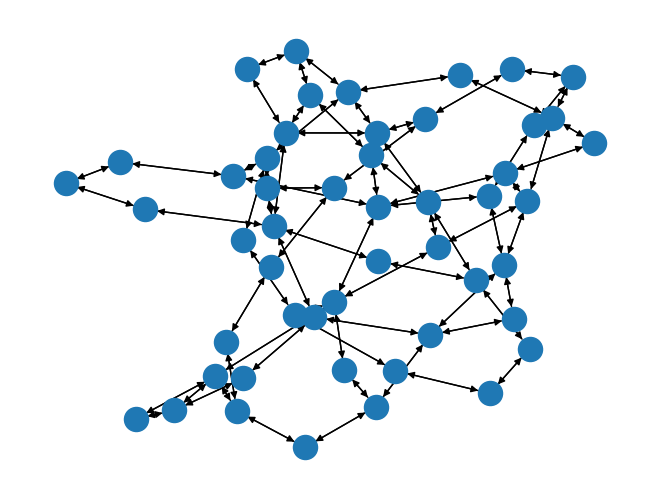

In [121]:
nx.draw(my_graph.G)

# Con

In [159]:
import torch.optim.adam


hiddens = reversed([256])
emb_dims = reversed([512])
bs = [1024]

n_obs = my_graph.state_dim
n_act = my_graph.action_dim
use_nn = True
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 700
lr = 1e-5
dataset_torch = GraphDataset(dataset, n_obs)

for hidden in hiddens:
    for emb_dim in emb_dims:
        for batch_size in bs:
            loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
            model = MyNNCML(
                emb_dim, n_obs, n_act, Q_init_stddev, V_init_stddev, W_init_stddev, use_nn=use_nn, hidden=hidden
            )
            loss = nn.MSELoss()
            if not model.use_nn:
                optim = torch.optim.Adam(
                    params=[
                        {"params": model.Q, "lr": eta_q / batch_size},
                        {"params": model.V, "lr": eta_v / batch_size},
                        {"params": model.W, "lr": eta_w / batch_size},
                    ],
                    lr=0.01,
                )
            else:
                optim = torch.optim.AdamW(
                    params=[
                        {"params": model.Q, "lr": lr*10},
                        {"params": model.V.parameters(), "lr": lr},
                        {"params": model.W, "lr": lr},
                    ],
                    lr=lr,
                    # weight_decay=1e-6
                )
            writer = SummaryWriter(f"""random_runs/{"nnCML" if use_nn else "CML"}-{str(map_size)}-{str(hidden) if use_nn else "0"}-{str(emb_dim)}-{str(batch_size)}-{lr}-Qnorm""")
            global_step = 0

            model.to('cuda')
            for epoch in range(num_epochs):
                for i, data in enumerate(loader):
                    # print(i)
                    optim.zero_grad()
                    output = model(data)
                    l = loss(output, torch.zeros_like(output))
                    l.backward()
                    optim.step()
                    global_step += 1
                    with torch.no_grad():
                        # if not model.use_nn:
                        model.Q /= torch.linalg.norm(model.Q, axis=0)
                    writer.add_scalar("train loss", l.detach().mean().item(), global_step)

            model.cpu()
            if not model.use_nn:
                Q, V = model.Q.detach().numpy(), model.V.detach().numpy()
            else:
                model.eval()
                Q = model.Q.detach().numpy()
                V = model.V.cpu()

            with torch.no_grad():
                N_goal = 200
                cml_distance = []
                cml_succ = 0
                dijkstra_distance = []
                graph = nx.from_numpy_array(
                    my_graph.adj_matrix, create_using=nx.DiGraph()
                )  # node_id is int, or else dijkstra will fail
                for process in range(N_goal):
                    # print(process)
                    start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
                    goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
                    # print(start, goal)

                    steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)

                    dijkstra_path = nx.shortest_path(
                        graph, source=start, target=goal, weight="weight"
                    )
                    dijkstra_steps = len(dijkstra_path) - 1

                    dijkstra_distance.append(dijkstra_steps)
                    if o_record[-1] == goal:
                        cml_distance.append(steps)
                        cml_succ += 1
                    # if dijkstra_steps > steps:
                        # print(o_record, dijkstra_path)

                # print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ)

            print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ / N_goal)
            writer.add_text("result", f"""{"nnCML" if use_nn else "CML"}, \n map_size: {str(map_size)}, n_obs: {n_obs}, n_act: {n_act}, \n hidden: {str(hidden) if use_nn else "0"}, embed: {str(emb_dim)}, BS: {str(batch_size)}, \n CML_AL: {np.mean(cml_distance)}, dj_AL: {np.mean(dijkstra_distance)}, SR: {cml_succ / N_goal}""")

6.475 5.38 1.0


# Dis

In [21]:
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
emb_dim = 128
hidden=512
use_nn = True
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10
batch_size = 1024
dataset_torch = GraphDataset(dataset, n_obs)
n_obs, n_act

(50, 709)

In [ ]:
loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
model = MyNNCML(
    emb_dim, n_obs, n_act, Q_init_stddev, V_init_stddev, W_init_stddev, use_nn=use_nn, hidden=hidden
)
loss = nn.MSELoss()
if not model.use_nn:
    optim = torch.optim.Adam(
        params=[
            {"params": model.Q, "lr": eta_q / batch_size},
            {"params": model.V, "lr": eta_v / batch_size},
            {"params": model.W, "lr": eta_w / batch_size},
        ],
        lr=0.01,
    )
else:
    optim = torch.optim.Adam(
        params=[
            {"params": model.Q, "lr": eta_q / batch_size},
            {"params": model.V.parameters(), "lr": eta_v / batch_size},
            {"params": model.W, "lr": eta_w / batch_size},
        ],
        lr=0.01,
    )
mses1 = []
writer = SummaryWriter(f"""random_runs/{"nnCML" if use_nn else "CML"}-{str(map_size)}-{str(hidden) if use_nn else "0"}-{str(emb_dim)}-{str(batch_size)}""")
global_step = 0

In [165]:
model.to('cuda')
for epoch in range(100):
    for i, data in enumerate(loader):
        # print(i)
        optim.zero_grad()
        output = model(data)
        l = loss(output, torch.zeros_like(output))
        # l.requires_grad_(True)
        l.backward()
        optim.step()
        global_step += 1
        with torch.no_grad():
            # if not model.use_nn:
                model.Q /= torch.linalg.norm(model.Q, axis=0)
        # mses1.append(l.detach().mean().item())
        writer.add_scalar("train loss", l.detach().mean().item(), global_step)

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(mses1, label="mses1")
# ax.set_title("Prediction errors during training")
# ax.set_yscale("log")
# plt.legend()
# plt.show()
# plt.close(fig)

In [167]:
model.cpu()
if not model.use_nn:
    Q, V = model.Q.detach().numpy(), model.V.detach().numpy()
else:
    model.eval()
    Q = model.Q.detach().numpy()
    V = model.V.cpu()

In [ ]:
# with torch.no_grad():
#     cml_distance = []
#     dijkstra_distance = []
#     graph = nx.from_numpy_array(my_graph.adj_matrix, create_using=nx.DiGraph())
#     start = my_graph.nodes_list.index((0, 0))
#     goal = my_graph.nodes_list.index((4, 4))
#     steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)
#     dijkstra_path = nx.shortest_path(graph, source=start, target=goal, weight="weight")
#     print(o_record, dijkstra_path)
#     dijkstra_steps = len(dijkstra_path) - 1
#     cml_distance.append(steps)
#     dijkstra_distance.append(dijkstra_steps)
#     # cml_distance, dijkstra_distance
#     np.mean(cml_distance), np.mean(dijkstra_distance)

In [ ]:
# removed_node_list = np.random.choice(len(my_graph.nodes_list), 1000, replace=False)
# my_graph.G.remove_nodes_from(removed_node_list)

In [168]:
with torch.no_grad():
    N_goal = 200
    cml_distance = []
    cml_succ = 0
    dijkstra_distance = []
    graph = nx.from_numpy_array(
        my_graph.adj_matrix, create_using=nx.DiGraph()
    )  # node_id is int, or else dijkstra will fail
    for process in range(N_goal):
        print(process)
        start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
        goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
        # print(start, goal)

        steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)

        dijkstra_path = nx.shortest_path(
            graph, source=start, target=goal, weight="weight"
        )
        dijkstra_steps = len(dijkstra_path) - 1

        dijkstra_distance.append(dijkstra_steps)
        if o_record[-1] == goal:
            cml_distance.append(steps)
            cml_succ += 1
        if dijkstra_steps > steps:
            print(o_record, dijkstra_path)
    # print(np.mean(cml_distance))
    # for _ in range(N_goal):
    #     start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
    #     goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
    #     dijkstra_path = nx.shortest_path(
    #         graph, source=start, target=goal, weight="weight"
    #     )
    #     dijkstra_steps = len(dijkstra_path) - 1
    #     dijkstra_distance.append(dijkstra_steps)
        # print(cml_distance, dijkstra_distance)
    print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
6.35 5.305 200


In [169]:
print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ / N_goal)
writer.add_text("result", f"""{"nnCML" if use_nn else "CML"}, \n map_size: {str(map_size)}, n_obs: {n_obs}, n_act: {n_act}, \n hidden: {str(hidden) if use_nn else "0"}, embed: {str(emb_dim)}, BS: {str(batch_size)}, \n CML_AL: {np.mean(cml_distance)}, dj_AL: {np.mean(dijkstra_distance)}, SR: {cml_succ / N_goal}""")

6.35 5.305 1.0
